In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spikeanal as spike
from pathlib import Path
from scipy.stats import sem

cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp', 'competition_closeness']

comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']
    compness = row['competition_closeness']
    comp_label = comp_closeness_dict.get(compness, "")  # Default to "" if not found

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"

        # Determine the new condition based on competition and win/lose logic
        if condition in ['rewarded', 'omission', 'both_rewarded', 'tie']:
            new_condition = condition
        else:
            win_or_lose = 'win' if str(condition) == str(subject) else 'lose'
            new_condition = f"{comp_label}_{win_or_lose}"

        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': new_condition,
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
valid_conditions = ['rewarded', 'omission', 'both_rewarded', 'tie', 'no_comp_win', 'no_comp_lose', 'competitive_win', 'competitive_lose']
timestamp_dicts = {}

for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in valid_conditions}
    if condition in valid_conditions:
        timestamp_dicts[key][condition].append(tuple_val)
    else:
        print(f"Unexpected condition: {condition} for subj_recording {key}")

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'from_cyborg'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec
<class '

In [3]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [4]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

In [5]:
# Assuming event_and_pre_event_spikes_df is already loaded
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,4.0,0.0,4.0,12.0,8.0,4.0,8.0,0.0,0.0,8.0
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,8.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,6.0,10.0,8.0,10.0,6.0,6.0,16.0,12.0,10.0,4.0
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,2.0,2.0,4.0,0.0,2.0,10.0,12.0,4.0,8.0,18.0
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,4.0,0.0,2.0,0.0,2.0,4.0,8.0,4.0,10.0,8.0
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,4.0,6.0,4.0,2.0,2.0,6.0,4.0,2.0


In [6]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434
...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359


In [7]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 1.65),
    (event_zscores_df['Event Z-Score'] < -1.65)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase


In [8]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase,pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig,interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig,pyramidal
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig,pyramidal
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig,pyramidal
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase,pyramidal


In [9]:
merged_df = merged_df[merged_df['Event name'] != 'tie']

In [10]:
sig_units = merged_df[merged_df['sig'] != 'not sig']

In [11]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo...",interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo...",pyramidal
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]",pyramidal


In [12]:
# Filter the units_df to include only rows where 'sig events' is not an empty list
sig_units2 = units_df[units_df['sig events'].apply(lambda x: len(x) > 0)].copy()

In [13]:
unit_sig_events = sig_units2.reset_index()
unit_sig_events = unit_sig_events['sig events']
event_types = ['competitive_win', 'competitive_lose', 'no_comp_win', 'no_comp_lose']

In [14]:
units_df['sig events'].value_counts()

sig events
[]                                                  441
[competitive_lose]                                   24
[no_comp_win]                                        11
[no_comp_lose]                                        9
[competitive_win]                                     6
[competitive_lose, no_comp_win]                       5
[competitive_lose, no_comp_lose, no_comp_win]         2
[competitive_win, no_comp_win]                        1
[competitive_lose, competitive_win, no_comp_win]      1
[competitive_lose, competitive_win]                   1
[competitive_win, no_comp_lose]                       1
Name: count, dtype: int64

In [15]:
sig_units

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.000000,0.000000,0.200000,inf,increase,pyramidal
5,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,24,1.500000,2.511512,5.900000,1.751933,increase,pyramidal
14,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,58,0.000000,0.000000,0.200000,inf,increase,pyramidal
33,20230612_101430_standard_comp_to_training_D1_s...,competitive_win,54,0.662500,0.592555,1.975000,2.214983,increase,pyramidal
74,20230612_101430_standard_comp_to_training_D1_s...,no_comp_win,53,0.000000,0.000000,0.020000,inf,increase,pyramidal
...,...,...,...,...,...,...,...,...,...
1674,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,3,6.100000,5.433986,19.200000,2.410753,increase,pyramidal
1675,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,4,14.100000,8.874625,32.100000,2.028255,increase,pyramidal
1676,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,no_comp_lose,7,4.800000,4.977900,13.700000,1.787903,increase,pyramidal
1700,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,competitive_lose,75,0.114286,0.265197,0.885714,2.908884,increase,pyramidal


# Increased smoothing window to 500

In [16]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, smoothing_window = 500, ignore_freq = 0.5)

All set to analyze


In [17]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

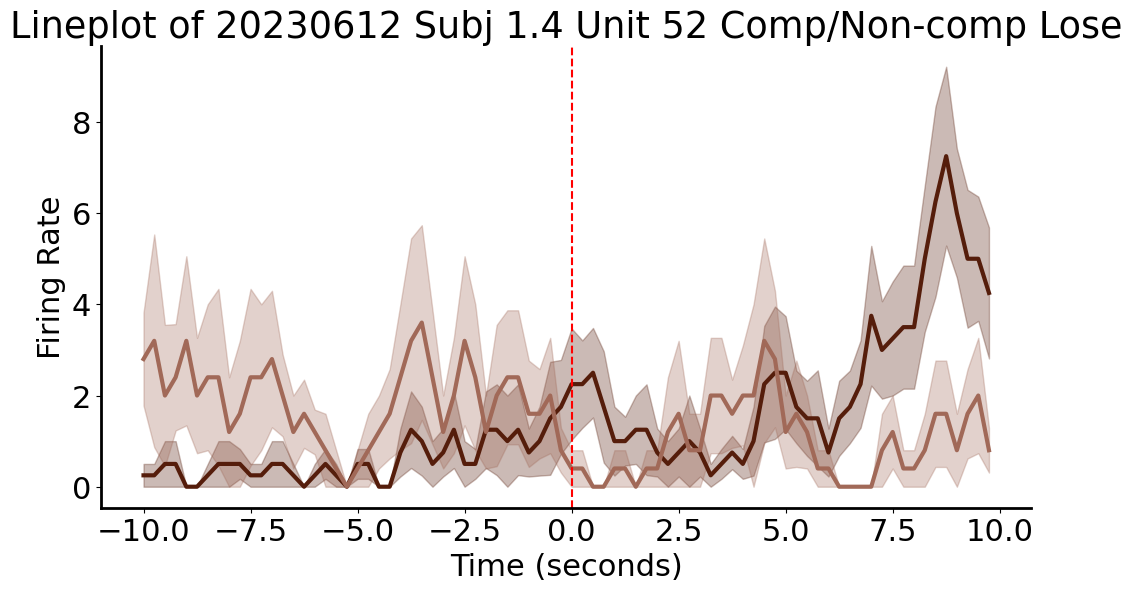

In [19]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec'
unit_to_plot = 52

# Define the events and their colors
events = {
    'competitive_lose': '#551d0b',
    'no_comp_lose': '#a16958'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Lose' if 'competitive' in event_name else 'Non-competitive Lose', color=color, linewidth=3)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'Competitive Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20230612 Subj 1.4 Unit 52 Comp/Non-comp Lose')

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Setting the linewidth of the x-axis and y-axis
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Save the pie chart without the legend
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(f'{directory}/Example_Lose_BothComp.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{directory}/Example_Lose_BothComp.jpg', format='jpg', bbox_inches='tight')

plt.show()

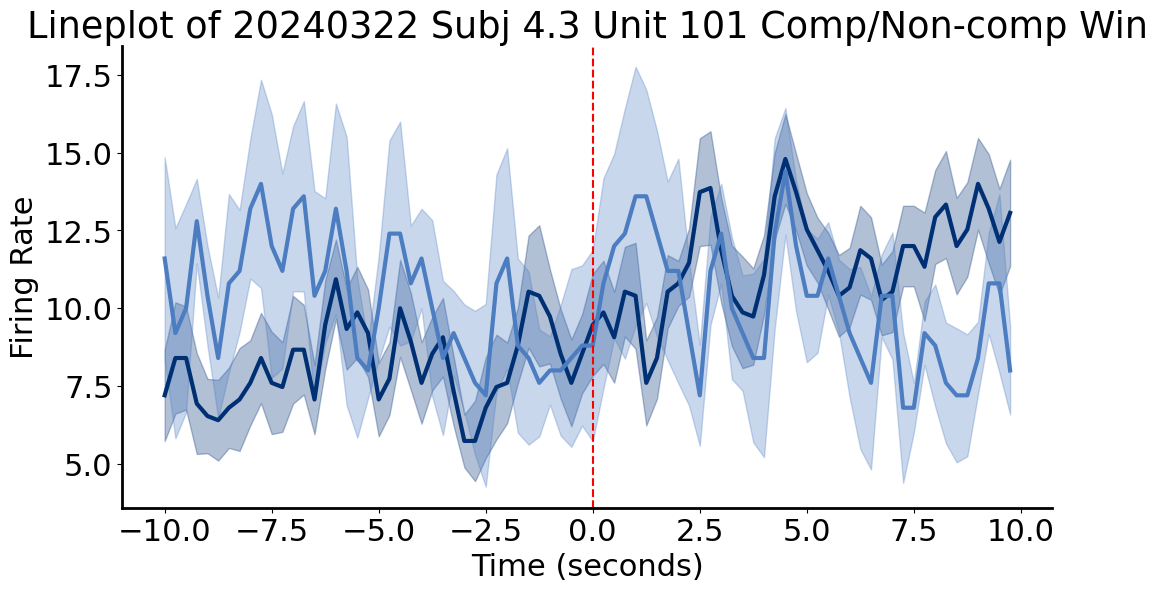

In [20]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20240322_160946_alone_comp_subj_4-3_t6b6_merged.rec'
unit_to_plot = 101

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color, linewidth=3)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'Competitive Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20240322 Subj 4.3 Unit 101 Comp/Non-comp Win')

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Setting the linewidth of the x-axis and y-axis
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Save the pie chart without the legend
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(f'{directory}/Example_Win_BothComp.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{directory}/Example_Win_BothComp.jpg', format='jpg', bbox_inches='tight')

plt.show()

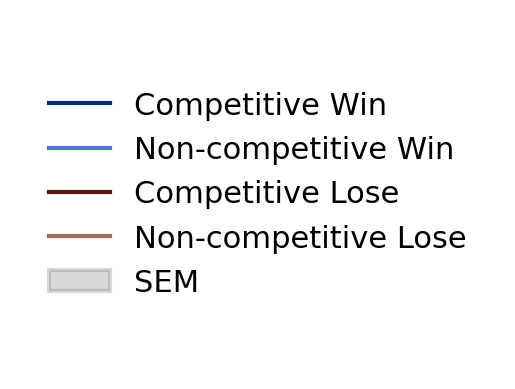

In [21]:
# Define the events and their colors for wins and losses
events_win = {
    'Competitive Win': '#003074',
    'Non-competitive Win': '#4d7dc1'
}

events_lose = {
    'Competitive Lose': '#551d0b',
    'Non-competitive Lose': '#a16958'
}

# Initialize plot - this will not display any actual data
fig, ax = plt.subplots()

# Create dummy plots for wins with a thicker line width
for label, color in events_win.items():
    ax.plot([], [], color=color, label=label, linewidth=3)

# Create dummy plots for losses with a thicker line width
for label, color in events_lose.items():
    ax.plot([], [], color=color, label=label, linewidth=3)

# Add SEM style
ax.fill_between([], [], [], color='grey', alpha=0.3, label='SEM', linewidth=3)

# Create the legend
legend = ax.legend(frameon=False, loc='center')
plt.gca().set_axis_off()

directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(f'{directory}/Example_Legend.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{directory}/Example_Legend.jpg', format='jpg', bbox_inches='tight')

plt.show()

# Other units I looked at below (doesn't reflect expected sig/non-sig):

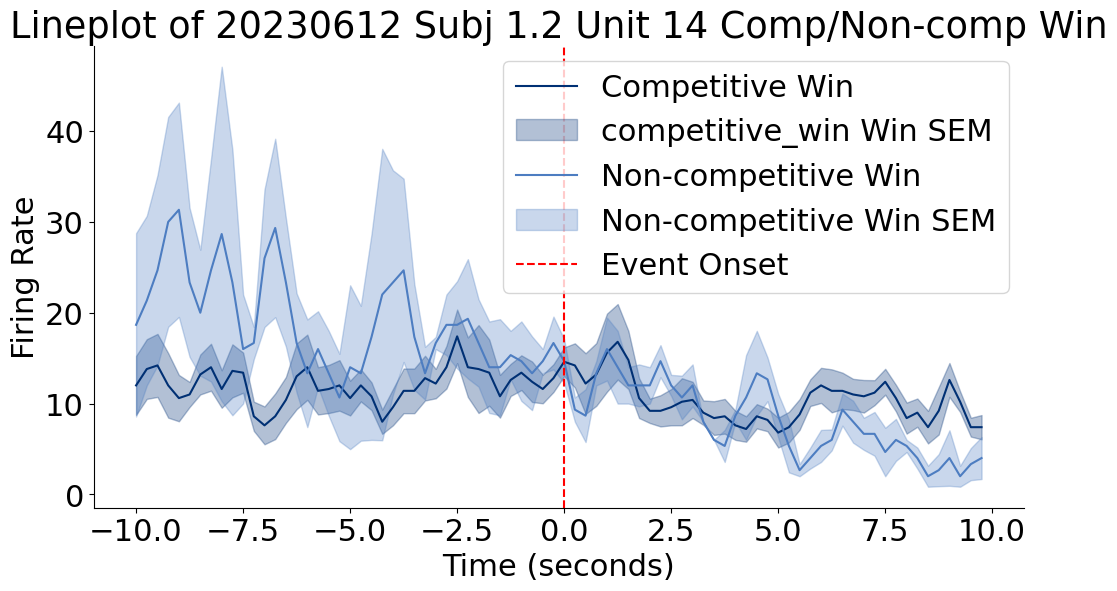

In [28]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec'
unit_to_plot = 14

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'{event_name} Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20230612 Subj 1.2 Unit 14 Comp/Non-comp Win')
ax.legend()

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

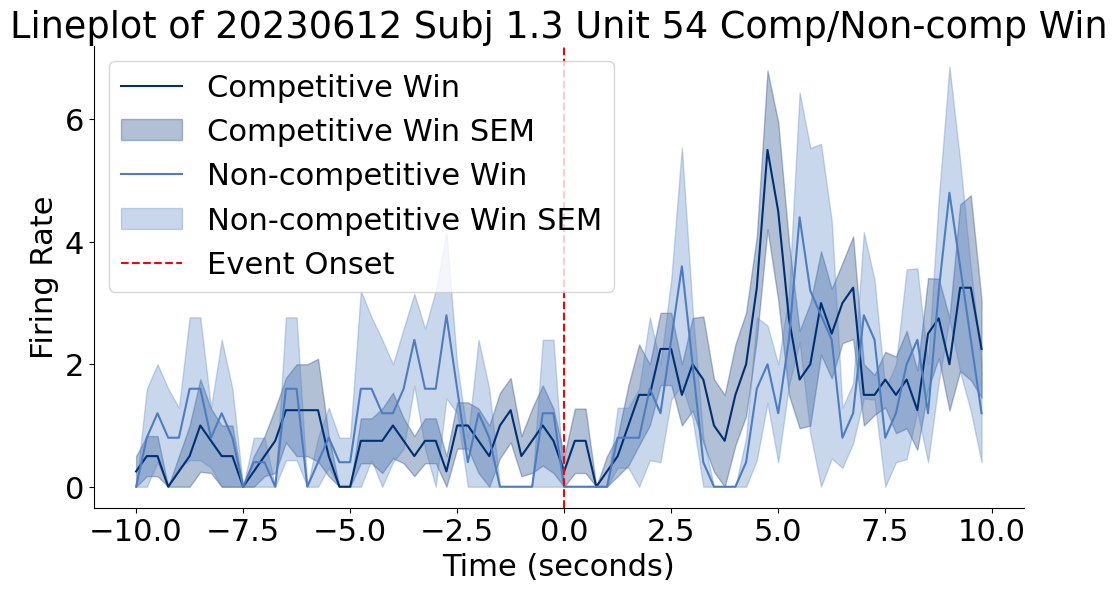

In [25]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec'
unit_to_plot = 54

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'Competitive Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20230612 Subj 1.3 Unit 54 Comp/Non-comp Win')
ax.legend()

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

SEM not plotted for competitive_win due to insufficient data.


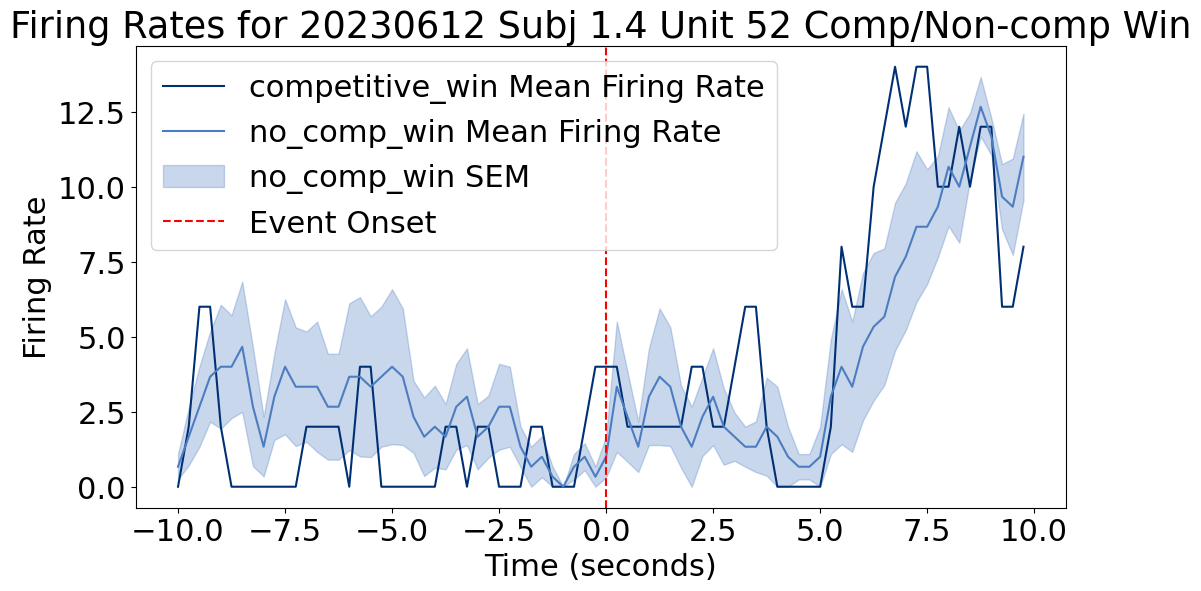

In [23]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec'
unit_to_plot = 52

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'{event_name} Mean Firing Rate', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'{event_name} SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Firing Rates for 20230612 Subj 1.4 Unit {unit_to_plot} Comp/Non-comp Win')
ax.legend()

plt.show()

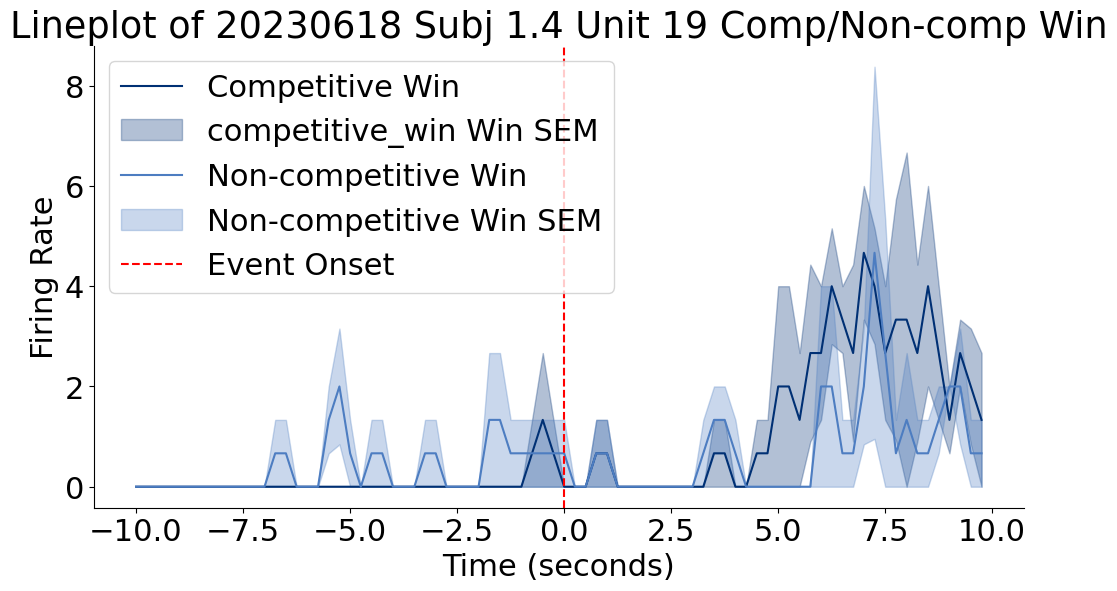

In [29]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec'
unit_to_plot = 19

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'{event_name} Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20230618 Subj 1.4 Unit 19 Comp/Non-comp Win')
ax.legend()

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

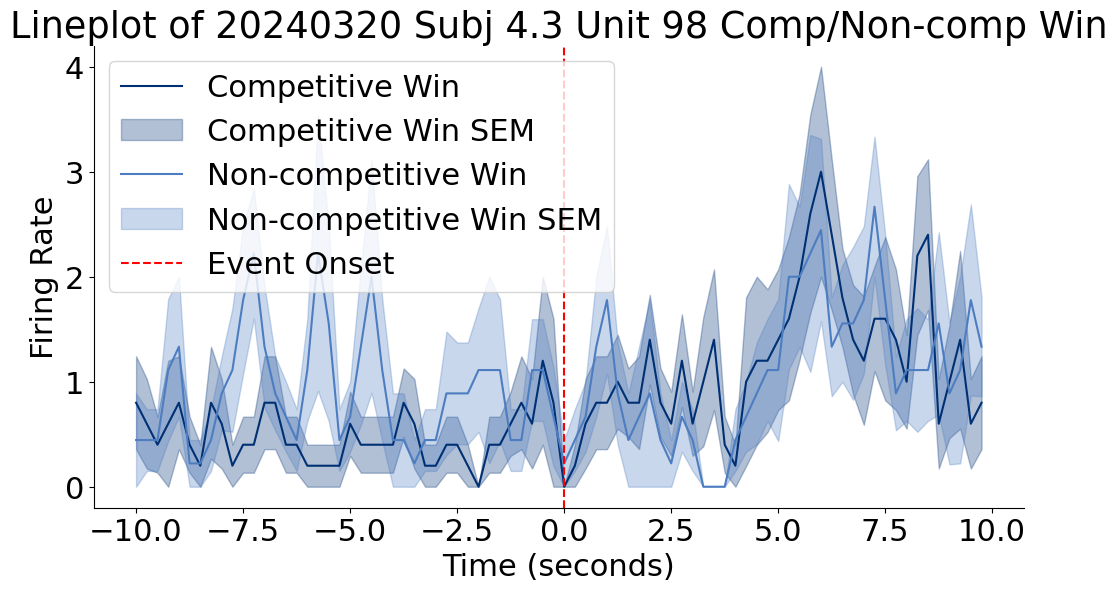

In [26]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20240320_171038_alone_comp_subj_4-3_t5b5_merged.rec'
unit_to_plot = 98

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'Competitive Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20240320 Subj 4.3 Unit 98 Comp/Non-comp Win')
ax.legend()

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

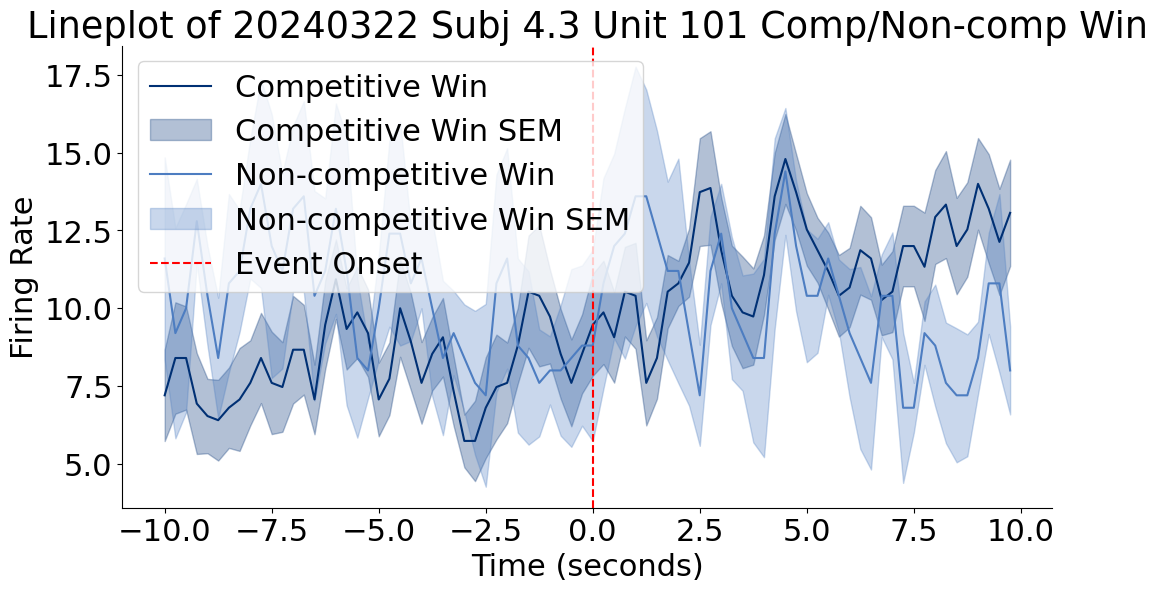

In [27]:
# Define the specific recording and unit you want to plot
recording_to_plot = '20240322_160946_alone_comp_subj_4-3_t6b6_merged.rec'
unit_to_plot = 101

# Define the events and their colors
events = {
    'competitive_win': '#003074',
    'no_comp_win': '#4d7dc1'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set font size
plt.rc('font', size=22)  # sets font size for all plot elements

# Calculate and plot for each event
for event_name, color in events.items():
    # Filter the DataFrame for the specific unit, recording, and event
    filtered_df = event_and_pre_event_spikes_df[
        (event_and_pre_event_spikes_df['Recording'] == recording_to_plot) &
        (event_and_pre_event_spikes_df['Unit number'] == unit_to_plot) &
        (event_and_pre_event_spikes_df['Event name'] == event_name)
    ]

    # Define the columns for pre-event and event timebins
    pre_event_columns = [f'Pre-event timebin {i}' for i in range(1, 41)]
    event_columns = [f'Event timebin {i}' for i in range(1, 41)]

    # Calculate means and SEM for each timebin
    pre_event_means = filtered_df[pre_event_columns].mean()
    pre_event_sems = filtered_df[pre_event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)
    event_means = filtered_df[event_columns].mean()
    event_sems = filtered_df[event_columns].apply(lambda x: sem(x) if x.count() > 1 else np.nan, axis=0)

    # Combine pre-event and event data for plotting
    all_means = np.concatenate([pre_event_means, event_means])
    all_sems = np.concatenate([pre_event_sems, event_sems])

    # Calculate timebins across the full range of pre-event and event periods
    timebins = np.linspace(-10, 10 - 0.25, 80)  # Adjusted to 80 total bins, each representing 250 ms

    # Plotting means and SEMs
    ax.plot(timebins, all_means, label=f'Competitive Win' if 'competitive' in event_name else 'Non-competitive Win', color=color)
    if not np.isnan(all_sems).all():
        ax.fill_between(timebins, all_means - all_sems, all_means + all_sems, color=color, alpha=0.3, label=f'Competitive Win SEM' if 'competitive' in event_name else 'Non-competitive Win SEM')
    else:
        print(f"SEM not plotted for {event_name} due to insufficient data.")

# Add event onset marker
ax.axvline(x=0, color='red', linestyle='--', label='Event Onset')

# Customize the plot
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Firing Rate')
ax.set_title(f'Lineplot of 20240322 Subj 4.3 Unit 101 Comp/Non-comp Win')
ax.legend()

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()